MedSRGAN 구현 

참고: https://github.com/04RR/MedSRGAN/

SRGAN: HR을 LR로 다운샘플링, GAN generator에 의해 LR이 SR 이미지로 업샘플링됨

In [32]:

import os
import random
from PIL import Image
import numpy as np
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from torch.nn.functional import interpolate
import torch.nn.functional as F

import torchvision.transforms as ttf
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.utils import make_grid
from torchvision import models

import matplotlib.pyplot as plt


In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor


# 난수 고정 함수
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 난수 고정
set_seed(42)

### Dataset

In [63]:
dataset_path = '/home/ykjeong/MedSRGAN/dataset/train'
path_list = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.png')]

class GAN_Data(Dataset):
    def __init__(self, path_list, transforms=None):
        super().__init__()
        self.path_list = path_list
        self.transforms = transforms
        self.t = ttf.Resize((256, 256))
        self.blur = ttf.GaussianBlur(3, sigma=(0.1, 2.0))
        
    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        image_path = self.path_list[idx]
        image = Image.open(image_path).convert('RGB').resize((512, 512))
        image = np.array(image) 
        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)
        
        if self.transforms:
            image = self.transforms(image)
    
        lr_image = self.blur(self.t(image))
        
        return lr_image.to(device) / 255., image.to(device) / 255.
    

transforms = ttf.Compose(
    [
        ttf.RandomHorizontalFlip(0.5),
        ttf.RandomVerticalFlip(0.5),
        ttf.RandomRotation((-15, 15)),
    ]
)

# 데이터셋 및 DataLoader 생성
train_dataset = GAN_Data(path_list, transforms)
train_dl = DataLoader(train_dataset, batch_size=1, shuffle=True)

#### dataset example 

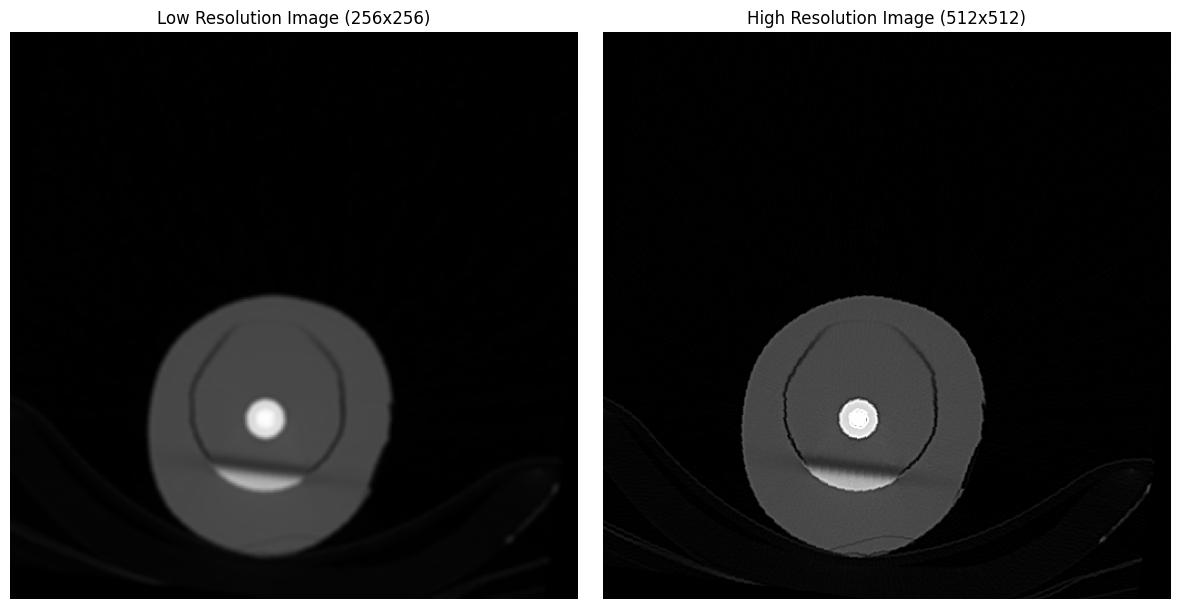

LR Image shape: (256, 256, 3)
HR Image shape: (512, 512, 3)


In [4]:
lr_img, hr_img = next(iter(train_dl))

# CPU로 이동하고 numpy 배열로 변환
lr_img = lr_img.cpu().numpy().squeeze().transpose(1, 2, 0)
hr_img = hr_img.cpu().numpy().squeeze().transpose(1, 2, 0)

# 이미지를 표시합니다
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(lr_img)
axes[0].set_title('Low Resolution Image (256x256)')
axes[0].axis('off')

axes[1].imshow(hr_img)
axes[1].set_title('High Resolution Image (512x512)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"LR Image shape: {lr_img.shape}")
print(f"HR Image shape: {hr_img.shape}")

### Modeling

In [5]:
class RWMAB(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.conv1(x)
        weights = self.sigmoid(out)
        out = x * weights 
        return out

class Generator(nn.Module):
    def __init__(self, in_channels=3, blocks=16):
        super().__init__()

        self.conv_input = nn.Conv2d(in_channels, 64, 3, padding=1)

        self.rwmab_blocks = nn.ModuleList(
            [RWMAB(64) for _ in range(blocks)]
        )

        self.conv_upsample = nn.Sequential(
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 3, 3, padding=1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.conv_input(x)
        
        for block in self.rwmab_blocks:
            out = out + block(out)
        
        out = self.conv_upsample(out)
        return out


In [6]:

class D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(D_Block, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.layer(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        # x1 처리 경로
        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1), nn.LeakyReLU(0.2)
        )
        self.block_1_1 = D_Block(64, 64, stride=2)
        self.block_1_2 = D_Block(64, 128, stride=2)
        self.block_1_3 = D_Block(128, 256, stride=2)
        self.block_1_4 = D_Block(256, 512, stride=2)
        self.block_1_5 = D_Block(512, 512, stride=2) 

        # x2 처리 경로
        self.conv_2_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1), nn.LeakyReLU(0.2)
        )
        self.block_2_1 = D_Block(64, 64, stride=2)
        self.block_2_2 = D_Block(64, 128, stride=2)
        self.block_2_3 = D_Block(128, 256, stride=2)
        self.block_2_4 = D_Block(256, 512, stride=2)

        # 공통 경로
        self.block3 = D_Block(1024, 512, stride=1)
        self.block4 = D_Block(512, 512, stride=2)
        self.block5 = D_Block(512, 512, stride=1)
        self.block6 = D_Block(512, 512, stride=2)
        self.block7 = D_Block(512, 1024, stride=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x1, x2):
        x1 = self.conv_1_1(x1)
        x1 = self.block_1_1(x1)
        x1 = self.block_1_2(x1)
        x1 = self.block_1_3(x1)
        x1 = self.block_1_4(x1)
        x1 = self.block_1_5(x1)  # 추가된 다운샘플링 블록 호출

        x2 = self.conv_2_1(x2)
        x2 = self.block_2_1(x2)
        x2 = self.block_2_2(x2)
        x2 = self.block_2_3(x2)
        x2 = self.block_2_4(x2)
        
        x = torch.cat([x1, x2], dim=1)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)


        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return torch.sigmoid(x)


In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19 = models.vgg19(weights=models.vgg.VGG19_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(vgg19.features.children())[:36])  # until conv4_4
        
        # Weights for combining losses on different layers
        self.weights = [0.5, 0.25, 0.125, 0.0625, 0.0625]
        
        # Layers for extracting features
        self.layers = [(1, 2), (2, 2), (3, 4), (4, 4), (5, 4)]
        
        # Ensure no gradients for VGG19 parameters
        for param in self.parameters():
            param.requires_grad = False
        
    def forward(self, hr_img, sr_img):
        hr_features = self.get_features(hr_img)
        sr_features = self.get_features(sr_img)
        
        loss_content = 0.0
        for i, (layer_idx, conv_idx) in enumerate(self.layers):
            hr_feat = hr_features[i]
            sr_feat = sr_features[i]
            loss_content += self.weights[i] * nn.functional.mse_loss(hr_feat, sr_feat)
        
        return loss_content
    
    def get_features(self, x):
        features = []
        for layer in self.features:
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                features.append(x)
        return features

In [8]:
gen = Generator().to(device)
disc = Discriminator(in_channels=3).to(device)

optimizer_G = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.9, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=1e-2, betas=(0.9, 0.999)) 

loss_function = torch.nn.L1Loss().to(device)
gan_loss = torch.nn.BCEWithLogitsLoss().to(device)
scaler = torch.cuda.amp.GradScaler()
feature_extractor = FeatureExtractor().to(device)

In [ ]:
def fit(
    gen,
    disc,
    feature_extractor,
    train_dl,
    epochs,
    optimizer_G,
    optimizer_D,
    scaler,
    loss_function,
    gan_loss,
):

    # 난수 고정
    set_seed(42)

    t_loss_G, t_loss_D = [], []

    for epoch in tqdm(range(epochs)):
        e_loss_G, e_loss_D = [], []

        for data in train_dl:
            lr_img, hr_img = data
            hr_img, lr_img = hr_img.cuda(), lr_img.cuda()
            
            # Discriminator의 출력 크기에 맞게 valid와 fake 텐서 생성
            valid = torch.ones((hr_img.size(0), 1), dtype=torch.float32, device=device, requires_grad=False)
            fake = torch.zeros((hr_img.size(0), 1), dtype=torch.float32, device=device, requires_grad=False)

            with torch.cuda.amp.autocast():

                # Train Generator

                pred_hr = gen(lr_img)
                pred_hr = interpolate(pred_hr, size=hr_img.shape[2:])
                # print(f'pred_hr shape: {pred_hr.shape}')

                content_loss = loss_function(pred_hr, hr_img)

                pred_features = [feature_extractor(hr_img=pred_hr, sr_img=pred_hr)]
                hr_features = [feature_extractor(hr_img=hr_img, sr_img=hr_img)]

                feature_loss = 0.0

                for pred_feature, hr_feature in zip(pred_features, hr_features):
                    feature_loss += loss_function(pred_feature, hr_feature)

                pred_real = disc(hr_img.detach(), lr_img)
                pred_fake = disc(pred_hr, lr_img)

                gan_loss_num = gan_loss(
                    pred_fake - pred_real.mean(0, keepdim=True), valid
                )

                loss_G = content_loss * 0.1 + feature_loss * 0.1 + gan_loss_num

                optimizer_G.zero_grad()
                scaler.scale(loss_G).backward()
                scaler.step(optimizer_G)
                scaler.update()
                e_loss_G.append(loss_G.item())  # 스칼라 값을 추가

                # Train Discriminator

                pred_real = disc(hr_img, lr_img)
                pred_fake = disc(pred_hr.detach(), lr_img)

                loss_real = gan_loss(pred_real - pred_fake.mean(0, keepdim=True), valid)
                loss_fake = gan_loss(pred_fake - pred_real.mean(0, keepdim=True), fake)

                loss_real_num = gan_loss(pred_real, valid)
                loss_fake_num = gan_loss(pred_fake, fake)

                loss_D = ((loss_real + loss_fake) / 2) + (
                    (loss_real_num + loss_fake_num) / 2
                )

                optimizer_D.zero_grad()
                scaler.scale(loss_D).backward()
                scaler.step(optimizer_D)
                scaler.update()
                e_loss_D.append(loss_D.item())  # 스칼라 값을 추가

        t_loss_D.append(sum(e_loss_D) / len(e_loss_D))
        t_loss_G.append(sum(e_loss_G) / len(e_loss_G))

        print(
            f"{epoch+1}/{epochs} -- Gen Loss: {sum(t_loss_G) / len(t_loss_G)} -- Disc Loss: {sum(t_loss_D) / len(t_loss_D)}"
        )

        # Save the models with epoch number
        torch.save(gen.state_dict(), f"./gen_{epoch+1}.pth")
        torch.save(disc.state_dict(), f"./disc_{epoch+1}.pth")

    return t_loss_G, t_loss_D

epochs=100
fit(gen, disc, feature_extractor, train_dl, epochs, optimizer_G, optimizer_D, scaler, loss_function, gan_loss)

### 

### test 

In [80]:
# 훈련된 모델 로드
gen_path = '/home/ykjeong/MedSRGAN/gen_100.pth'
disc_path = '/home/ykjeong/MedSRGAN/disc_100.pth'
test_folder = '/home/ykjeong/MedSRGAN/dataset/test'

# 모델 가중치 로드
gen.load_state_dict(torch.load(gen_path))
disc.load_state_dict(torch.load(disc_path))

<All keys matched successfully>

In [74]:
test_path = [os.path.join(test_folder, f) for f in os.listdir(dataset_path) if f.endswith('.png')]

# 데이터셋 및 DataLoader 생성
test_dataset = GAN_Data(test_path, transforms)
test_dl = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [84]:

# PSNR 계산 함수
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

PSNR between HR and Generated HR: 32.810306549072266


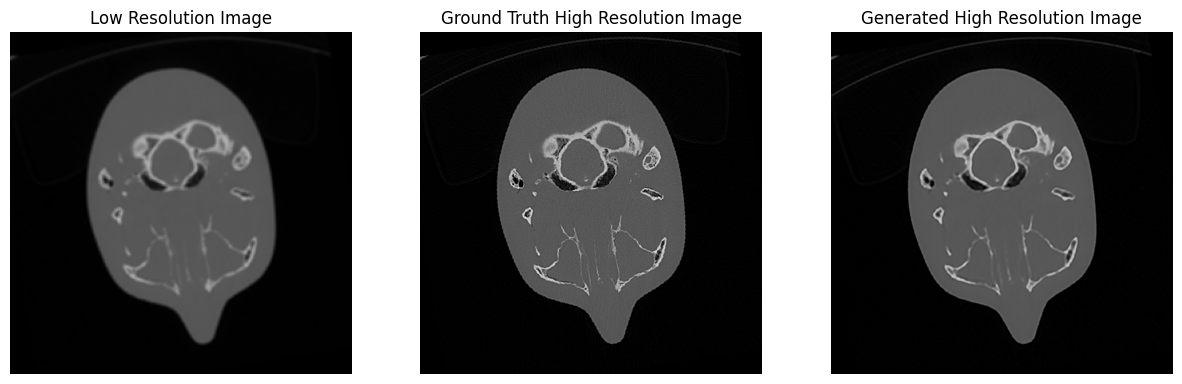

In [86]:
# 테스트 루프
gen.eval()
with torch.no_grad():
    for lr_img, hr_img in test_dl:
        lr_img, hr_img = lr_img.cuda(), hr_img.cuda()
        
        # 이미지 생성
        gen_hr_img = gen(lr_img)
        gen_hr_img = F.interpolate(gen_hr_img, size=hr_img.shape[2:])
        
        
        # PSNR 계산
        psnr_hr_gen_hr = calculate_psnr(hr_img, gen_hr_img)

        print(f"PSNR between HR and Generated HR: {psnr_hr_gen_hr}")

        # 이미지를 [0, 1] 범위로 변환
        to_pil = ToPILImage()

        lr_img = to_pil(lr_img.squeeze(0).cpu())
        hr_img = to_pil(hr_img.squeeze(0).cpu())
        gen_hr_img = to_pil(gen_hr_img.squeeze(0).cpu())

        # 이미지 시각화
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(lr_img)
        axes[0].set_title('Low Resolution Image')
        axes[0].axis('off')

        axes[1].imshow(hr_img)
        axes[1].set_title('Ground Truth High Resolution Image')
        axes[1].axis('off')

        axes[2].imshow(gen_hr_img)
        axes[2].set_title('Generated High Resolution Image')
        axes[2].axis('off')

        plt.show()

        # 하나의 배치만 시각화하고 종료
        break